In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dense(2, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()
decoder.summary()
#load the data and split into train + test sets
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
vae.fit(x=x_train,y=x_train, shuffle=True, epochs=10, batch_size=batch_size)
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

TensorFlow is already loaded. Please restart the runtime to change versions.
2.4.1
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
_________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


**HOMEWORK 1** 

Interpolate between two latent vectors (i.e., moving in the latent space) and decode and visualize the interpolations. Provide a code (python notebook) to do this interpolation; and provide 3 interpolated images in-between.

In [2]:
def interpolate_and_vis(num1, num2, num_of_images):
  idex_num1 = [idx for idx in range(len(y_test)) if y_test[idx] == num1]
  idex_num2 = [idx for idx in range(len(y_test)) if y_test[idx] == num2]

  encoded_num1 = encoded[idex_num1]
  encoded_num2 = encoded[idex_num2]

  idx1 = np.random.choice(idex_num1)
  idx2 = np.random.choice(idex_num2)

  mu1, sigma1 = encoded[idx1]
  mu2, sigma2 = encoded[idx2]

  mu_linspace = np.linspace(mu1, mu2, num_of_images)
  sigma_linspace = np.linspace(sigma1, sigma2, num_of_images)

  params = np.array(list(zip(mu_linspace, sigma_linspace)))
  decoded = decoder.predict(params)

  print('First base image, from class: ', num1)
  plt.matshow(x_test[idx1][:,:,0], cmap='gray')
  plt.show()

  print('Second base image, from class: ', num2)
  plt.matshow(x_test[idx2][:,:,0], cmap='gray')
  plt.show()
  print('\n\n')

  for index, param in enumerate(params):  
    print('Image num: ', index+1)
    plt.matshow(decoded[index][:,:,0], cmap='gray')
    plt.show()


First base image, from class:  2


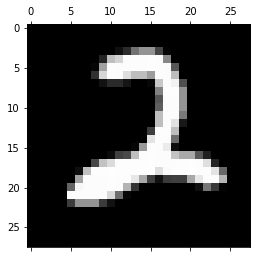

Second base image, from class:  8


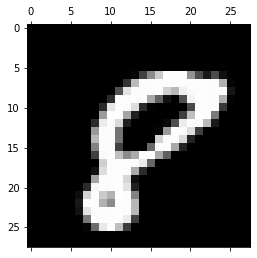




Image num:  1


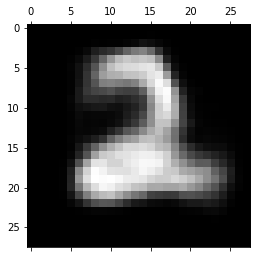

Image num:  2


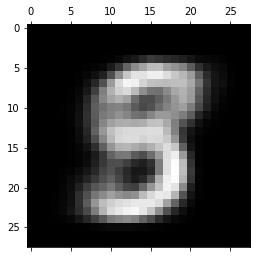

Image num:  3


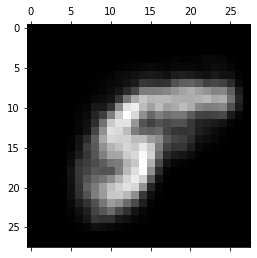

In [3]:
# between 2 and 8
interpolate_and_vis(2, 8, 3)

First base image, from class:  4


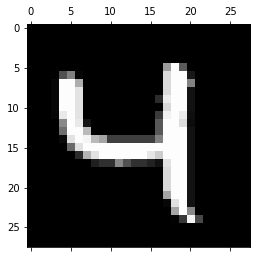

Second base image, from class:  0


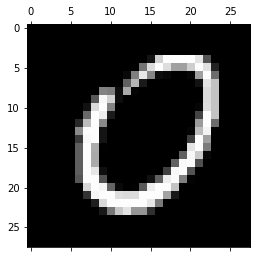




Image num:  1


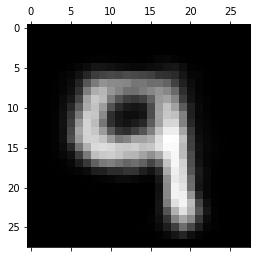

Image num:  2


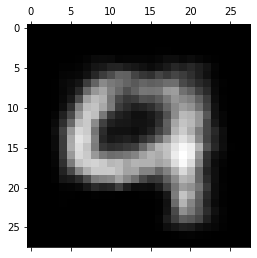

Image num:  3


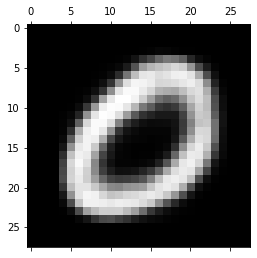

In [4]:
# between 4 and 0
interpolate_and_vis(4, 0, 3)

**HOMEWORK 2** 

Apply VAE on the above ST data. Modify the earlier VAE architecture (used on MNIST), such as input data dimensions and other parameters (strides, layers, etc). Keep the 2 dimensions as latent variables.
Visualize the scatter plot.
Visualize the reconstructed data as the 2D heatmap.
Make sure to submit the jupyterlab code.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
#file = 'drive/MyDrive/Colab Notebooks/Rep01_MOB_count_matrix-1.tsv'
file = '/content/drive/MyDrive/Colab Notebooks/Rep1_MOB_count_matrix-1.tsv'
data_orig = pd.read_csv(file, sep='\t')
x = [float(i.partition('x')[0]) for i in data_orig.iloc[:,0]]
y = [float(i.partition('x')[2]) for i in data_orig.iloc[:,0]]
x_round = [int(i+0.5) for i in x] 
y_round = [int(i+0.5) for i in y]
data = []
    
#loop over genes
for i in range(1,data_orig.shape[1]):
    mat = np.zeros([32,32])
    #fill spatial arrays for each gene
    for x_, y_, val in zip(x_round, y_round, data_orig.iloc[:,i]):
        mat[y_,x_] = val
    #scaling the data on each gene from 0 to 1
    mat = mat/(mat.max())
    data.append(mat)
data = np.array(data)

Mounted at /content/drive


In [72]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

img_shape = (32, 32, 1)
batch_size = 16
latent_dim = 2
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='sigmoid')(x)


shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)


z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()
decoder.summary()
#load the data and split into train + test sets
cut_point = round(len(data) * 0.8)
x_train = data[:cut_point]
x_test = data[cut_point:]
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

TensorFlow is already loaded. Please restart the runtime to change versions.
2.4.1
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   18496       conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 64)   36928       conv2d_15[0][0]                  
________

In [73]:
vae.fit(x=x_train, y=x_train, shuffle=True, epochs=10, batch_size=batch_size)

Train on 13258 samples
Epoch 1/10
13258/13258 [==============================] - 4s 311us/sample - loss: 0.0340
Epoch 2/10
13258/13258 [==============================] - 4s 271us/sample - loss: 8.3309e-04
Epoch 3/10
13258/13258 [==============================] - 4s 269us/sample - loss: 7.7646e-04
Epoch 4/10
13258/13258 [==============================] - 4s 268us/sample - loss: 7.5625e-04
Epoch 5/10
13258/13258 [==============================] - 4s 270us/sample - loss: 7.4923e-04
Epoch 6/10
13258/13258 [==============================] - 4s 269us/sample - loss: 7.4597e-04
Epoch 7/10
13258/13258 [==============================] - 4s 273us/sample - loss: 7.4378e-04
Epoch 8/10
13258/13258 [==============================] - 4s 270us/sample - loss: 7.4215e-04
Epoch 9/10
13258/13258 [==============================] - 4s 273us/sample - loss: 7.4100e-04
Epoch 10/10
13258/13258 [==============================] - 4s 272us/sample - loss: 7.4034e-04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


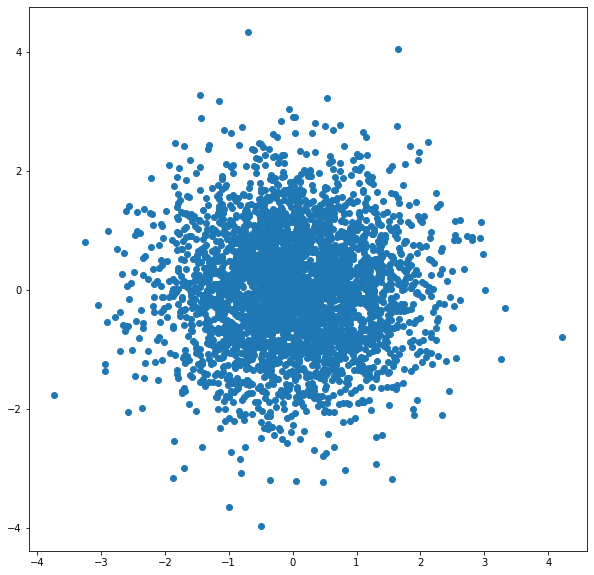

In [74]:
x_test_encoded_st = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.savefig('scatter_st.png')
plt.show()

In [75]:
def heatmap(num_of_images):
  mu_linspace = np.linspace(-8, 8, num_of_images)
  sigma_linspace = np.linspace(-4, -4, num_of_images)

  params = np.array(list(zip(mu_linspace, sigma_linspace)))
  decoded_new = decoder.predict(params).reshape(num_of_images, 32, 32)

  for index, param in enumerate(params):  
    print('Image num: ', index+1)
    plt.matshow(decoded_new[index])
    plt.show()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Image num:  1


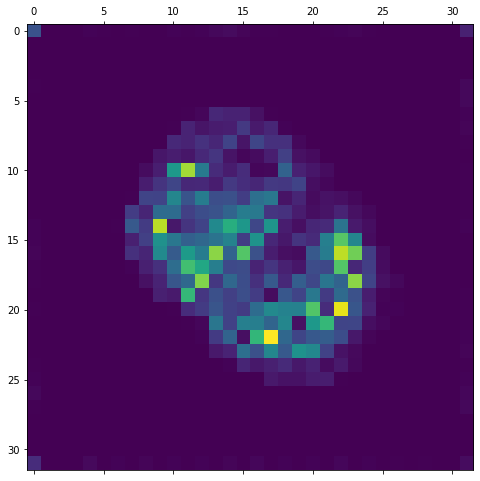

Image num:  2


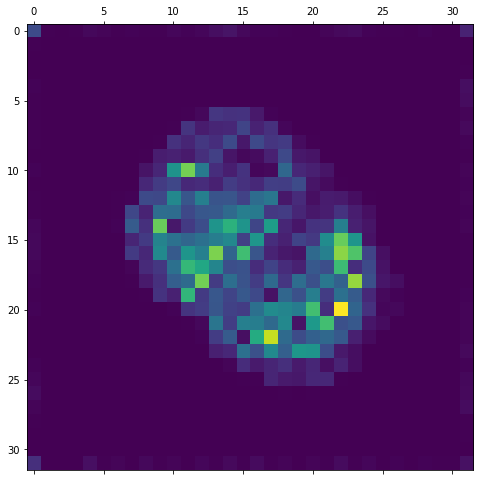

Image num:  3


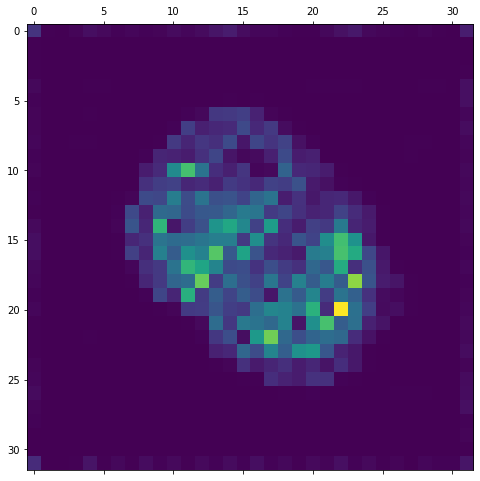

Image num:  4


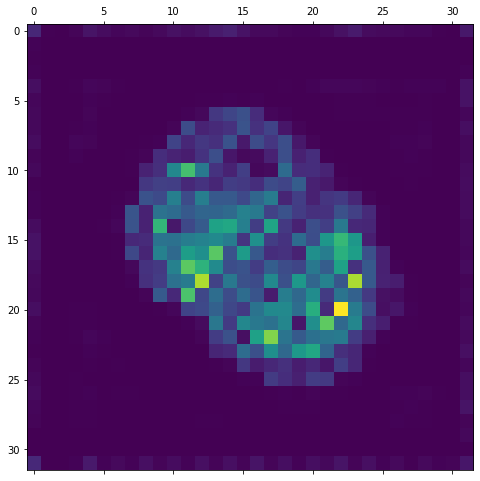

Image num:  5


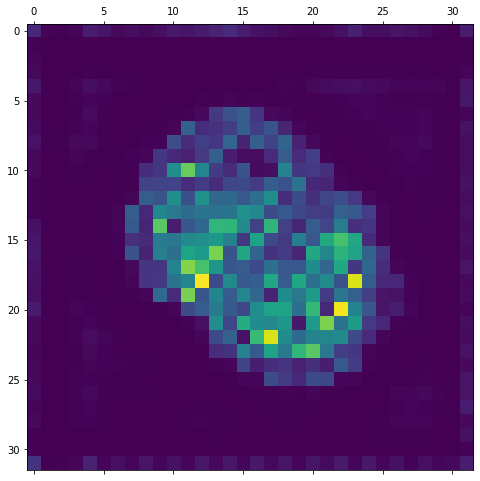

Image num:  6


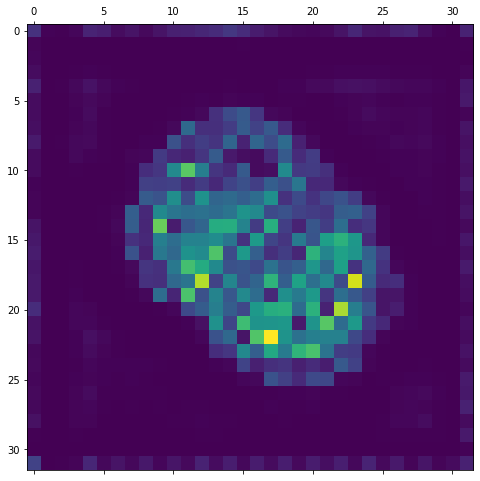

Image num:  7


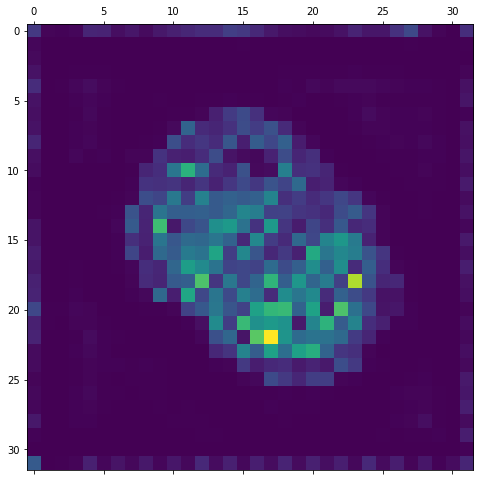

Image num:  8


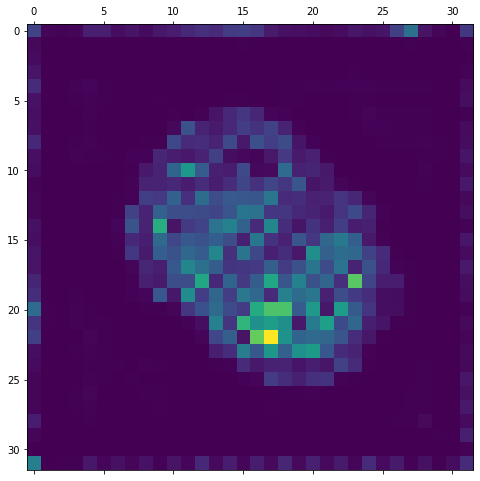

Image num:  9


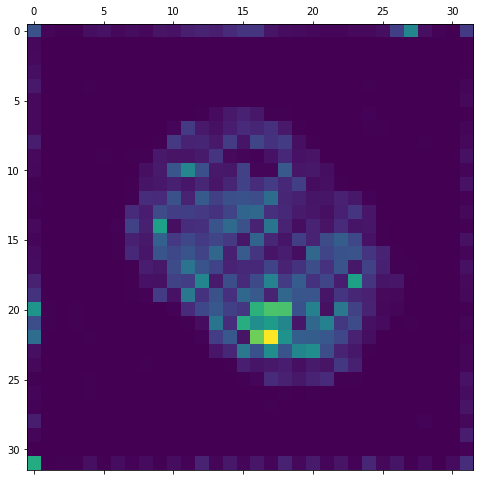

Image num:  10


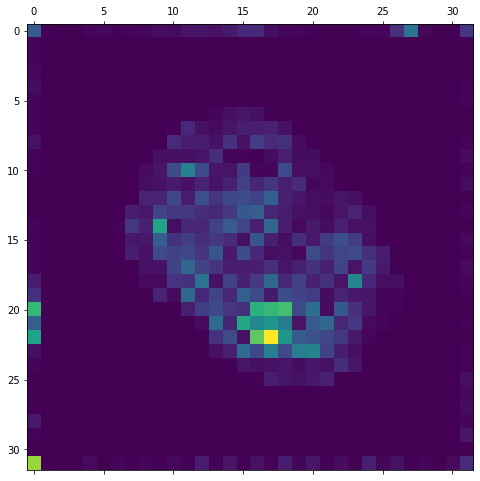

In [76]:
heatmap(10)